In [32]:
import sys
import os
import numpy as np
import cv2 
import albumentations as aug
import pandas as pd
from random import randint
import random
import matplotlib.pyplot as plt

In [33]:
class augmentor():
    
    def __init__(self):
        
         self.aug={}
            
         self.aug['rc']=aug.augmentations.transforms.RandomResizedCrop(2000, 2000, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1, always_apply=False, p=1.0) 
         self.aug['rg']=aug.Compose([aug.augmentations.transforms.RandomGamma(gamma_limit=(80, 120))], keypoint_params=aug.KeypointParams(format='xy'))
         self.aug['cl']=aug.Compose([aug.augmentations.transforms.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)], keypoint_params=aug.KeypointParams(format='xy'))  
         

    def __call__(self,image,keypoints,augment="hf"):
        kpts=[]
            
        while(len(kpts)!=4):
            augmented=self.aug[augment](image=image,keypoints=keypoints)
            kpts=augmented['keypoints']    
          
        return augmented['image'],augmented['keypoints']
    
    
    def background(self,image):

        augmented=self.aug["rc"](image=image)
        return augmented['image']


In [140]:
imp = '/home//synthetic data/fore_img'
bgp = '/home//synthetic data/back_img'

filters=['cl','rg']
filt_weigh=[5,10]
augment=augmentor()

In [141]:
def load_images(fore_img,back_img,f_size_ran,b_size_ran):
    
    fore=os.path.join(imp, fore_img)
    back=os.path.join(bgp, back_img)
            
    fore=cv2.imread(fore)
    back=cv2.imread(back)
          
    xf=randint(f_size_ran[0],f_size_ran[1])
    yf=int(fore.shape[0]/fore.shape[1]*xf)
            
    x=randint(int(xf*2),b_size_ran[1])
    y=randint(int(yf*2),b_size_ran[1])
        
    f_size=(xf,yf)
    b_size=(x,y)
    
    fig = plt.figure(figsize=(15, 15))
        
    fig.add_subplot(1, 2, 1)
    plt.imshow(fore)
    plt.title("Foreground")

    fig.add_subplot(1, 2, 2)
    plt.imshow(back)
    plt.title("Background")
    
    return fore, back, f_size, b_size

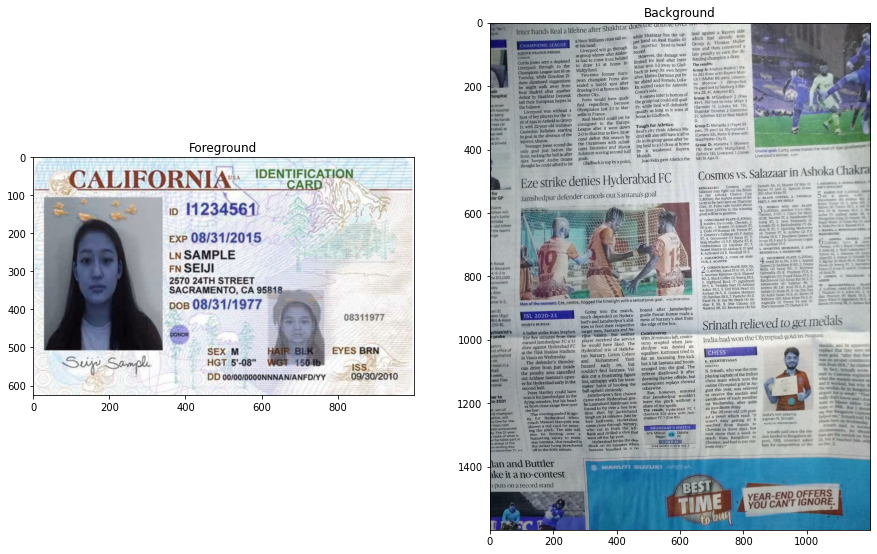

In [142]:
fore, back, f_size, b_size = load_images('2.png','1.jpg',(300,390),(1000,1024))

In [143]:
def back_randomcrop(fore, back, f_size, b_size, randomcrop=False):
    if(randomcrop):
        back=augment.background(back)
    
    fore=cv2.resize(fore,f_size,interpolation = cv2.INTER_AREA)
    back=cv2.resize(back,b_size,interpolation = cv2.INTER_AREA)        
        
    (yf,xf,c)=fore.shape
    pts=np.array(([(0,0),(xf,0),(xf,yf),(0,yf)]))# initial points
            
    plt.figure(figsize=(10, 10))
    plt.imshow(back)
    plt.title("Randomcrop Background")

    return fore,back,pts

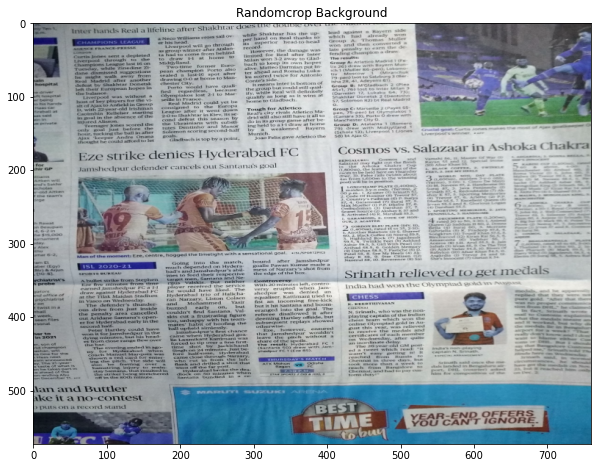

In [144]:
fore, back, pts = back_randomcrop(fore, back, f_size, b_size)

In [145]:
def getPerspectiveTransform(image):
    
    strength = random.randint(40,80)
    
    (yf,xf,c)=image.shape
    pts_base=np.float32(([(0,0),(xf,0),(xf,yf),(0,yf)]))
    
    pts=np.random.rand(4, 2)*random.uniform(-strength,0)+pts_base

    pts=pts.astype(np.float32)

    M = cv2.getPerspectiveTransform(pts, pts_base)
    trans_img = cv2.warpPerspective(image, M, (int(xf*1.5),int(yf*1.5)),cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

    pts=np.array((pts), np.int32)
    pts[:,0]-=min(pts[:,0])
    pts[:,1]-=min(pts[:,1])
    plt.imshow(trans_img)

    return trans_img,pts

In [146]:
def fore_transform(fore, pts, rot_prob=1):
    
    if(randint(0,rot_prob)==0):
        fore=fore.astype("float32")
        fore=fore+1
        fore,pts=getPerspectiveTransform(fore)
        fore=fore-1
        
    plt.figure(figsize=(10, 10))
    plt.imshow(fore)
    plt.title("PerspectiveTransform")
        
    return fore

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


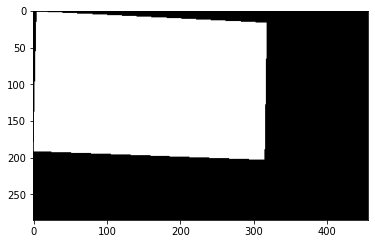

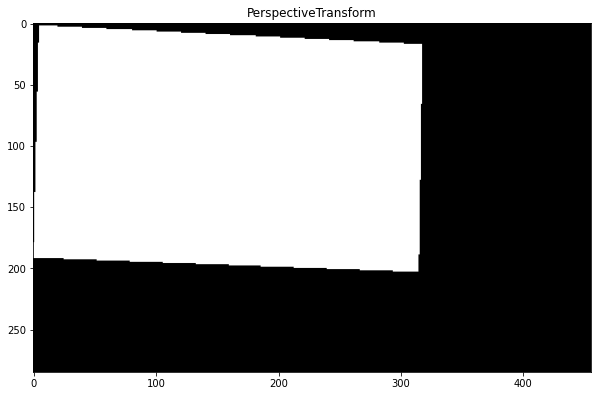

In [147]:
fore = fore_transform(fore, pts)

In [148]:
def getpos(fore,back):
    
    f_size=fore.shape
    b_size=back.shape
    
    
    assert(b_size[0]>f_size[0] and b_size[1]>f_size[1]) 
    
    x1=f_size[0]
    x2=b_size[0]
        
    y1=f_size[1]
    y2=b_size[1]
        
    x=randint(0,(x2-x1))
    y=randint(0,(y2-y1))
       
    return (x,y)

In [149]:
pos=getpos(fore,back)

In [150]:
def stack_image(imgb,img2,pos):
       
    posx,posy=(pos)
    img1=imgb.copy()
    (w,h,c)=img2.shape
       
    crp=img1[posx:posx+w,posy:posy+h,:]
    crp[np.where(img2>=0)]=img2[np.where(img2>=0)].ravel()
    img1[posx:posx+w,posy:posy+h,:]=crp
    
    plt.figure(figsize=(10,10))
    plt.imshow(img1)
    
    return img1 

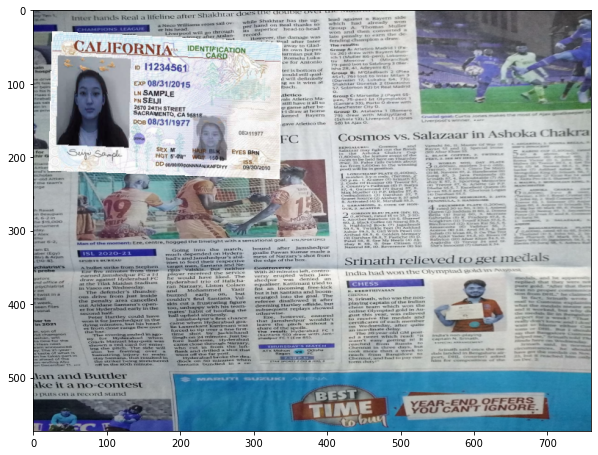

In [151]:
new_img = stack_image(back,fore,pos) 

In [152]:
def getpoints(pts,pos):
    (yp,xp)=pos        
    points=pts+np.array([xp,yp])
    return points  

In [153]:
point=getpoints(pts, pos)

In [154]:
def get_filter():
    return random.choices(filters, weights=filt_weigh, k=1)[0]

In [155]:
augimg, augpts = augment(new_img, point, augment = get_filter())

In [156]:
def crop_with_kp(image,kp):
       
    pts=np.array((kp), np.int32)
        
    minx=min(pts[:,0])
    maxx=max(pts[:,0])
    miny=min(pts[:,1])
    maxy=max(pts[:,1])
    
    y,x,_=image.shape
    xl=randint(0,minx)
    xr=randint(maxx,x-1)
    yu=randint(0,miny)
    yd=randint(maxy,y-1)
    new_img=image[yu:yd,xl:xr,:]
    pts=pts-np.array(([xl,yu]))
    
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
    
    return new_img,pts

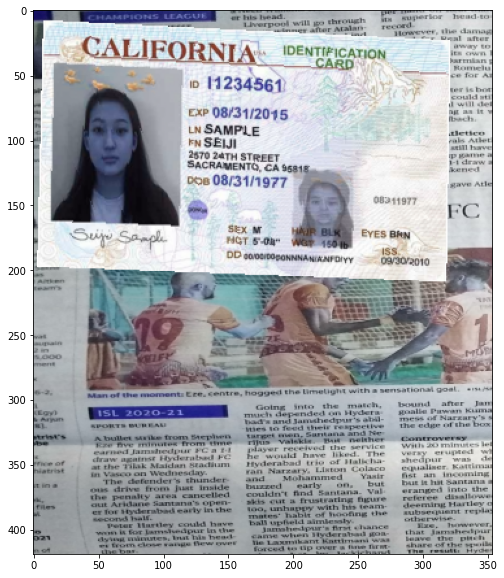

In [157]:
img,pts = crop_with_kp(new_img, point)

In [158]:
def save_image(img): 
    path = '/home/synthetic data/data'
    name = 'image_1'
    cv2.imwrite(os.path.join(path ,name+'.jpg'), img)

In [159]:
save_image(img)